In [1]:
import numpy as np
import matplotlib.pyplot as plt

## a)

Text(0.5, 1.0, 'Original Map')

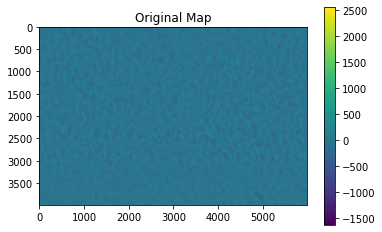

In [2]:
from astropy.io import fits
hdul=fits.open('advact_tt_patch.fits')
map=hdul[0].data
hdul.close()
map=np.asarray(map,dtype='float')
width = 20
patch = map[1999-width:1999+width,2999-width:2999+width]
plt.imshow(map)
plt.colorbar()
plt.title("Original Map")

on interation  0  parameters are  [   9.75881785    9.68323728  -39.98899538    1.6456759  -134.22287183]
on interation  1  parameters are  [   9.27102981    5.28343442 -130.56877873    8.7828492  -123.20266329]
on interation  2  parameters are  [  10.12087485   12.08461919 -228.41263435    5.63711058   -5.72565158]
on interation  3  parameters are  [   9.7402335     7.44525047 -148.62051402    5.18316336  -80.59332514]
on interation  4  parameters are  [   9.80153948    8.99525577 -172.63337126    3.54606699 -103.39284038]
on interation  5  parameters are  [   9.75571846    8.44929035 -213.18579082    2.97644151 -111.47545657]
on interation  6  parameters are  [   9.80740533    8.66008571 -210.98808778    3.17483822 -110.33333751]
on interation  7  parameters are  [   9.79223982    8.63132911 -210.82843993    3.21875394 -109.35931124]
on interation  8  parameters are  [   9.79143876    8.63245772 -210.36883949    3.23334715 -109.12584924]
on interation  9  parameters are  [   9.790885

Text(0.5, 1.0, 'Residuals plot')

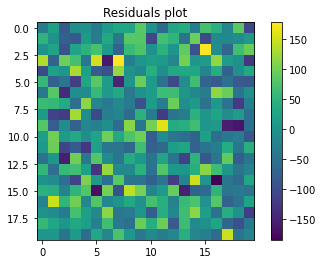

In [3]:
import numpy as np
from astropy.io import fits
from matplotlib import pyplot as plt
plt.ion()


def smooth_map(map,npass):
    tmp=map.copy()
    for i in range(npass):
        tmp=tmp+np.roll(map,1,0)+np.roll(map,-1,0)+np.roll(map,1,1)+np.roll(map,-1,1)
        tmp=tmp/5
    return tmp

def pad_map(map):
    map=np.hstack([map,np.fliplr(map)])
    map=np.vstack([map,np.flipud(map)])
    return map


def gauss2d(pars,x):
    x0=pars[0]
    y0=pars[1]
    amp=pars[2]
    sig=pars[3]
    c=pars[4]
    
    dx=x-x0
    dy=x-y0
    
    dxmat=np.outer(dx,np.ones(len(dx)))
    dymat=np.outer(np.ones(len(dy)),dy)
    rsqr=dxmat**2+dymat**2
    map=amp*np.exp(-.5*rsqr/sig**2) + c
    return map

def get_derivs_ravel(fun,pars,dp,x):
    mymod=fun(pars,x)
    npar=len(pars)
    dplus=[None]*npar
    dminus=[None]*npar
    for i in range(npar):
        pp=pars.copy()
        pp[i]=pp[i]+dp[i]
        dplus[i]=fun(pp,x)
        pp=pars.copy()
        pp[i]=pp[i]-dp[i]
        dminus[i]=fun(pp,x)
    n=dplus[0].size
    A=np.empty([n,npar])
    #actually do the numerical derivatives
    for i in range(npar):
        dd=(dplus[i]-dminus[i])/(2*dp[i])
        A[:,i]=np.ravel(dd)
        
    return np.ravel(mymod),A

def newton(pars,fun,data,x,dp,niter=10):
    for i in range(niter):
        mod,A=get_derivs_ravel(fun,pars,dp,x)
        r=data-mod
        n_inv = 1/np.std(data)
        lhs=n_inv*A.T@A
        rhs=n_inv*A.T@r
        dp=np.linalg.inv(lhs)@rhs
        pars=pars+dp
        print('on interation ',i,' parameters are ',pars)
    return pars

hdul=fits.open('advact_tt_patch.fits')
map=hdul[0].data
hdul.close()
map=np.asarray(map,dtype='float')

#center of the original map
x0=1999
y0=2999


#The patch I use for getting the best fit parameters
width=10
patch=map[x0-width:x0+width,y0-width:y0+width]
x=np.arange(0,patch.shape[0])

#The source in the center which corresponds to [width,width] pixels on the patch, giving the initial amp as the min
#value on the map, sig = 1 and the constant c as 0
guess=np.asarray([width,width,patch.min(),1.0,0])
model=gauss2d(guess,x)
dp=np.asarray([0.01,0.01,-1.0,0.01,0.01])
mod,derivs=get_derivs_ravel(gauss2d,guess,dp,x)

fitp=newton(guess,gauss2d,np.ravel(patch),x,dp)
modfit=gauss2d(fitp,x)
print("Final best-fit parameters after 10 iterations of newton method ", fitp)
plt.imshow(modfit-patch)
plt.colorbar()
plt.title("Residuals plot")

## b)

In [7]:
def get_gauss_kernel(map,sig,amp,c,dx,dy,norm=False):
    nx=map.shape[0]
    x=np.fft.fftfreq(map.shape[0])*map.shape[0] - dx
    y=np.fft.fftfreq(map.shape[1])*map.shape[1] - dy
    rsqr=np.outer(x**2,np.ones(map.shape[1]))+np.outer(np.ones(map.shape[0]),y**2)
    kernel=np.exp((-0.5/sig**2)*rsqr)*amp + c
    if norm:
        kernel=kernel/kernel.sum()
    return kernel

def estimate_ps2(pad_fun, data):
    #pad the input map and take it's FT
    patch2 = pad_fun(data)
    patchft=np.fft.fft2(patch2)
    #FT of patchft again as patchft has to be convolved with a gaussian
    patchft_ft = np.fft.fft2(np.abs(patchft)**2)
    #The gaussian template with the sigma as the sigma obtained from the best fit (3.23882668), amp = 1, 
    #center = (0,0) and c=0
    gauss = get_gauss_kernel(patch2,3.23882668,1,0,0,0, norm=True)
    #the next lines of code to ensure that the gaussian and the FT(FT(padded map)) have the same dimensions
    x = patch2.shape[0]
    y = patch2.shape[1]
    width = gauss.shape[0]/2
    gauss_full = np.zeros([x,y])
    p = 0
    for i in np.arange(int(x/2-width),int(x/2+width)):
        q = 0
        for j in np.arange(int(y/2-width),int(y/2+width)):
            gauss_full[i][j] = gauss[p][q]
            q+=1
        p+=1
    #FT of the gaussian and then IFT to get the convolved map
    gauss_ft = np.fft.fft2(gauss_full)
    smoothm = np.fft.irfft2(gauss_ft*patchft_ft, patch2.shape)
    return smoothm

Text(0.5, 1.0, 'Log of the power spectrum')

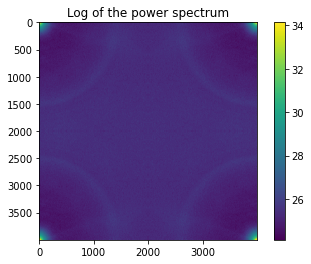

In [30]:
#For the analysis, I use a 2000x2000 patch from the original map, as my code takes too long to run on the 
#original map (and this patch includes the galaxy that I need to identify for part 6)
#center of the original map
x0=1999
y0=2999
width = 1000
map_new = map[x0-width:x0+width,y0-width:y0+width]
smoothm = estimate_ps2(pad_map, map_new)
plt.imshow(np.log(smoothm))
plt.colorbar()
plt.title("Log of the power spectrum")

## c) 

In [31]:
def filter_map(map, ps, pad_fun):
    pad_map = pad_fun(map)
    n_pix = pad_map.size
    #Normalising the filtered map by dividing the power spectrum by the number of pixels.
    Ninv=1/(ps/n_pix)  
    #This noise matrix is uncorrelated in the fourier space
    data_ft=np.fft.fft2(pad_map)
    filt_map=np.fft.irfft2(data_ft*Ninv, pad_map.shape) #Getting back into real space
    filt_map= filt_map[:map.shape[0],:map.shape[1]] #Getting the non-padded map from the padded map
    return filt_map

Text(0.5, 1.0, 'Log of the power spectrum of the residuals')

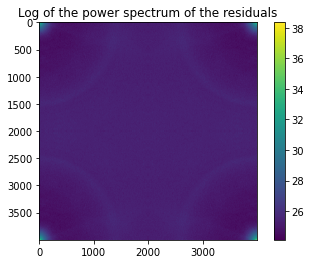

In [32]:
#The "ideal" best fit center of the cluster in part 1 should have been (10,10), but the best fit returned 
#(9.79073657, 8.6313414). So, the cluster is off from the center of the map by (dx, dy) amount
dx = 10 - 9.79073657
dy = 10 - 8.6313414
#Putting the sig, amp, c and center of the map obtained from the best-fit in part 1. 
gauss_fit = get_gauss_kernel(map_new,3.23882668,-210.18367169,-109.04243493,dx, dy)
#Making sure that the gauss template and the map has the same dimensions
x = map_new.shape[0]
y = map_new.shape[1]
width = gauss_fit.shape[0]/2
gauss_full = np.zeros([x,y])
p = 0
for i in np.arange(int(x/2-width),int(x/2+width)):
    q = 0
    for j in np.arange(int(y/2-width),int(y/2+width)):
        gauss_full[i][j] = gauss_fit[p][q]
        q+=1
    p+=1
#Getting the residuals from the fit 
resid = map_new - gauss_full
#Getting the power spectrum from the residuals
ps = estimate_ps2(pad_map, resid)
plt.imshow(np.log(ps))
plt.colorbar()
plt.title("Log of the power spectrum of the residuals")

Text(0.5, 1.0, 'Filter map')

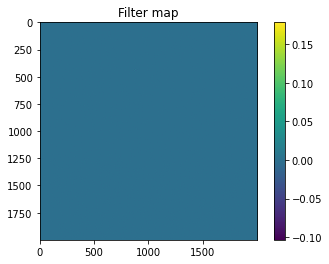

In [33]:
filt_map = filter_map(map_new, ps, pad_map)
plt.imshow(filt_map)
plt.colorbar()
plt.title("Filter map")

Text(0.5, 1.0, 'Similar patch of the original map')

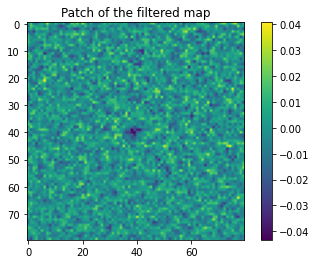

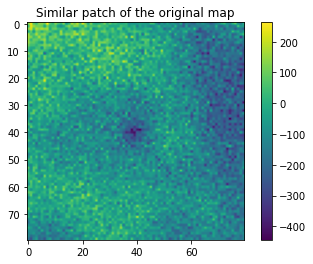

In [34]:
#Patch of the filter map centered at the center of the original map
#Map center
x0=1000
y0=1000
width=40
filt_patch=filt_map[x0-width:x0+width,y0-width:y0+width]

plt.imshow(filt_patch)
plt.colorbar()
plt.title("Patch of the filtered map")
plt.figure()
plt.imshow(map_new[x0-width:x0+width,y0-width:y0+width])
plt.colorbar()
plt.title("Similar patch of the original map")

As can be seen, the filtered map has uncorrelated noise! 

## d)

Text(0.5, 1.0, 'Filtered map for the input white noise map')

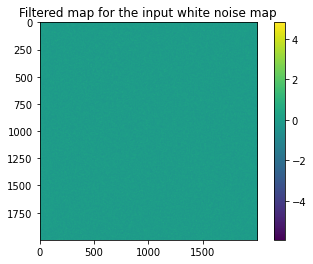

In [36]:
#Generating a map of the white noise, and getting it's filter map
map_test = np.zeros([map_new.shape[0], map_new.shape[1]])
map_test = np.random.randn(map_test.shape[0], map_test.shape[1]).copy()
ps_test = estimate_ps2(pad_map, map_test)
filt_map_test = filter_map(map_test, ps_test, pad_map)
plt.figure()
plt.imshow(filt_map_test)
plt.colorbar()
plt.title("Filtered map for the input white noise map")

In [37]:
print("Mean and std of the original white noise map: m = {}, std = {}".format(np.mean(map_test),np.std(map_test)))

Mean and std of the original white noise map: m = -0.00012766840596836298, std = 1.0003788986583046


In [38]:
print("Mean and std of the filtered white noise map: m = {}, std = {}".format(np.mean(filt_map_test),np.std(filt_map_test)))

Mean and std of the filtered white noise map: m = -9.06758060581218e-05, std = 0.9925094004141256


As can be see, the std (and hence variance) of the filtered map is close to the expected value of 1, so the map is properly normalised! 

## e)

In [39]:
#Getting the template gauss signal, simialar to what I did in part c
dx = 10 - 9.79073657
dy = 10 - 8.6313414
padm = pad_map(map_new)
n_pix = padm.size
gauss_fit = pad_map(get_gauss_kernel(map_new,3.23882668,-210.18367169,-109.04243493,dx, dy))
#FT of the gauss template
tft=np.fft.fft2(gauss_fit)
#Normalising the power spectrum of the residuals
Ninv=1/(ps/n_pix)
#FT of the input padded map
datft=np.fft.fft2(padm)
#Correlation of the input map with A^TN^-1
Ninvt=tft*Ninv
mf_rhs=np.fft.irfft2(Ninvt*np.conj(datft), datft.shape)
#Getting lhs = A^TN^-1A (where A is the gaussian template)
Ninv_A = np.fft.irfft2(Ninvt, datft.shape)
mf_lhs = gauss_fit.T@Ninv_A
#Getting the best-fit parameter which is the amplitude of the gaussian
amp = np.linalg.pinv(mf_lhs)@mf_rhs
#This will return the amp of the padded map. Next steps get the amp of the original map
amp_cut = amp[:map_new.shape[0],:map_new.shape[1]]
#amp at the center of the map where our galaxy cluster is 
print("Best-fit amp at the center of the map is : {}".format(amp_cut[1000,1000]))

Best-fit amp at the center of the map is : -398396625.487954


In [40]:
#Error in the amplitude
error = np.sqrt(np.abs(np.linalg.pinv(mf_lhs)))
#Error in amp for the non-padded map
error_cut = error[:map_new.shape[0],:map_new.shape[1]]
print("Error ar the center of the map is {}".format(error_cut[1000,1000]))

Error ar the center of the map is 330.72059101422695


Text(0.5, 1.0, 'Amplitude map around the center where there is a galaxy cluster')

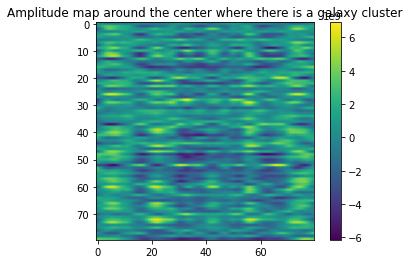

In [60]:
#The amplitude map around the center where there is a galaxy cluster
plt.imshow(amp_cut[1000-40:1000+40,1000-40:1000+40])
plt.colorbar()
plt.title("Amplitude map around the center where there is a galaxy cluster")

In [42]:
#Std around the center of the map where there is a galaxy cluster
print("Standard deviation of the matched filter output in a region around the cluster = {}".format(np.std(amp_cut[1000-10:1000+10,1000-10:1000+10])))

Standard deviation of the matched filter output in a region around the cluster = 1958258094.789334


As returned by the matched filter fit, the amp at the center of the cluster is -398396625.487954 +- 330.72059101422695 uK. The error is very small compared to the std I get in a region around the cluster, so I do not buy the error bars

## f)

Text(0.5, 1.0, 'Map with A2813 at (50,50)')

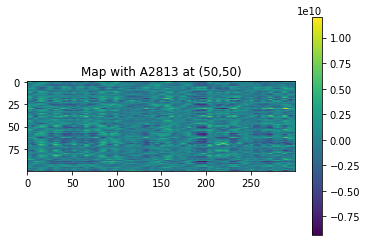

In [54]:
plt.imshow(amp_cut[1000-50:1000+50,1000-50:1000+250])
plt.colorbar()
plt.title("Map with A2813 at (50,50)")

I can see the presence of a galactic cluster at about (200,50) but could not find a matching galaxy in the NED.

Text(0.5, 1.0, 'Map with A2813 at (100,100)')

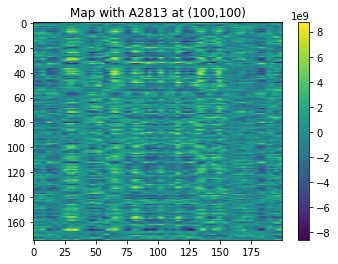

In [59]:
plt.imshow(amp_cut[1000-100:1000+75,1000-100:1000+100])
plt.colorbar()
plt.title("Map with A2813 at (100,100)")

Similarly, I also see a galaxy cluster like feature at about (100,170), but do not find a matching galaxy in the NED.